In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from scipy.linalg import cholesky, lstsq


In [3]:
import pyproj

pyproj.datadir.set_data_dir("/home/atmo/bin/anaconda3/envs/rmaiwald_dev/share/proj")


/home/atmo/bin/anaconda3/envs/rmaiwald_dev/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [4]:
from experiments import EffectCorrelation
from experiments import utilities as utils
from bayesinverse import Regression


In [5]:
config_path = config_path = Path(
    "/home/rmaiwald/code/Experiments/experiments/effect_correlation/config.yaml"
)

exp = EffectCorrelation(config_path)


sensors 0.003155827522277832


/home/rmaiwald/code/Experiments/experiments/shared/emissions.py:301: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  tno_points_gdf = pickle.load(file)


emissions 2.454549863934517
transport 5.006688088178635


In [6]:
meteo_seed = 2
n_processes = 32
exp.K = exp.transport.get_transport(
    exp.sensors.n_sensors,
    exp.sensors.get_index(),
    exp.emissions,
    n_processes=n_processes,
    seed=meteo_seed,
)


loop start 63.05015291273594
loop end 63.12585160136223


In [7]:
reg = Regression(
    y=utils.stack_xr(exp.K @ exp.emissions.truth + exp.sensors.get_noise()),
    K=utils.stack_xr(exp.K),
    x_prior=utils.stack_xr(exp.emissions.prior),
    x_covariance=utils.stack_xr(exp.emissions.prior_covariance),
    y_covariance=utils.stack_xr(exp.sensors.get_covariance()),
)


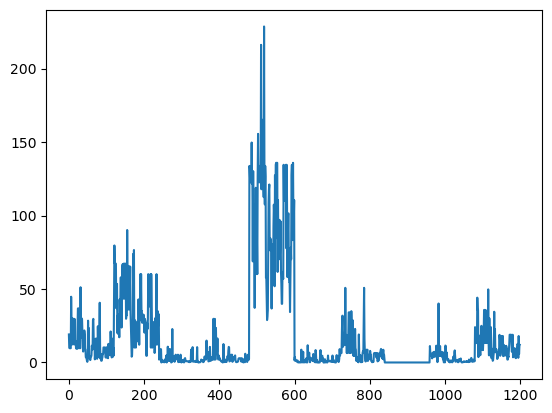

In [8]:
plt.plot(utils.stack_xr(exp.K).values.sum(axis=1))


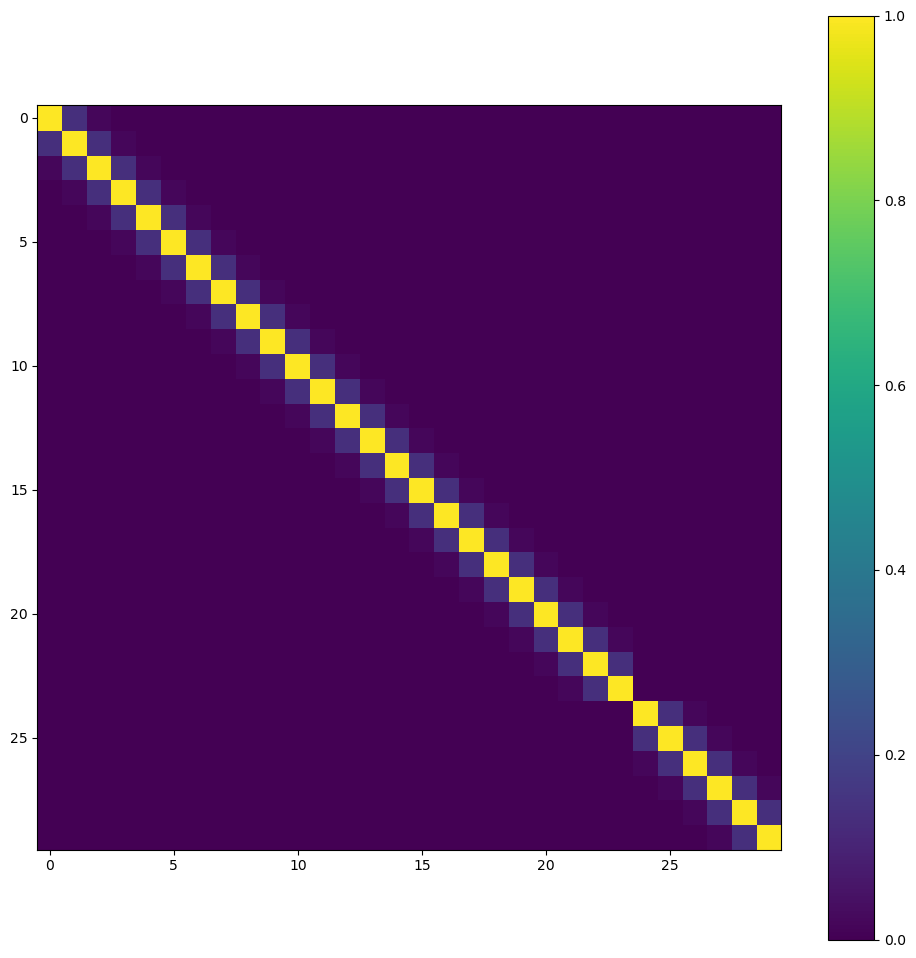

In [9]:
plt.figure(figsize=(12, 12))
plt.imshow(utils.stack_xr(exp.emissions.prior_covariance)[:30, :30])
plt.colorbar()


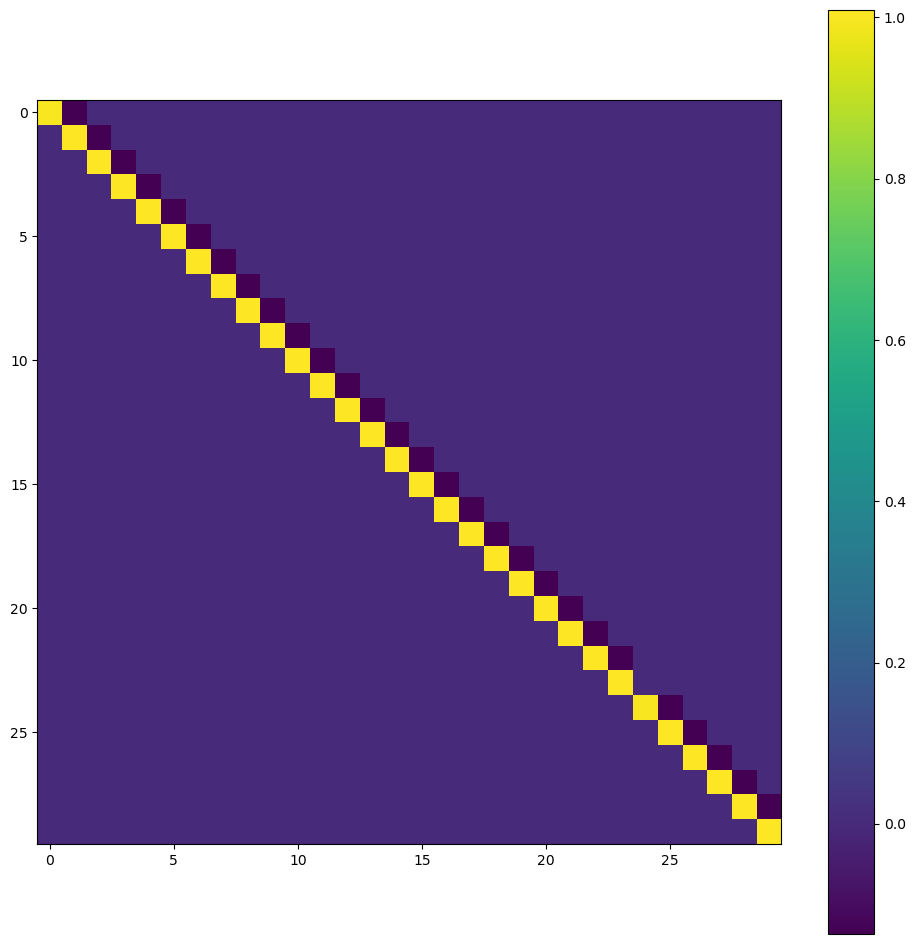

In [10]:
plt.figure(figsize=(12, 12))
plt.imshow(reg.model.x_covariance_inv_sqrt[:30, :30])
plt.colorbar()


In [11]:
reg.get_averaging_kernel().min()


-3.2590847905301996

In [12]:
true_emissions = exp.emissions.get_absolute()[exp.emissions.mask]


In [13]:
corr_strength_list = [1e-8 + 1.0 * i for i in range(30)]
tau_h = 1.0
tau_d = 0.00001

reg = Regression(
    y=utils.stack_xr(exp.K @ exp.emissions.truth + exp.sensors.get_noise()),
    K=utils.stack_xr(exp.K),
    x_prior=utils.stack_xr(exp.emissions.prior),
    x_covariance=utils.stack_xr(exp.emissions.prior_covariance),
    y_covariance=utils.stack_xr(exp.sensors.get_covariance()),
)

rmse_list = []
posterior_list = []
posterior_covariance_list = []
for corr_strength in corr_strength_list:
    print(corr_strength)
    prior_covariance = utils.compute_prior_covariance(
        xr_prior_var=exp.emissions.prior_variance,
        tau_h=corr_strength * tau_h,
        tau_d=corr_strength * tau_d,
    )
    reg.set_x_covariance(utils.stack_xr(prior_covariance))
    x_est, _, _, _ = reg.fit()
    x_posterior = exp.emissions.to_xr(x_est)
    x_posterior = utils.unstack_xr(x_posterior) * true_emissions

    error = x_posterior - exp.emissions.truth_absolute
    rmse = np.sqrt(np.mean(error.sum("source_group") ** 2))
    # rmse = np.mean(
    #     np.abs(
    #         (
    #             exp.emissions.truth_absolute.sum("source_group")
    #             - (utils.unstack_xr(x_posterior) * exp.emissions.truth_absolute).sum(
    #                 "source_group"
    #             )
    #         )
    #     )
    # )
    rmse_list.append(rmse)
    posterior_list.append(x_posterior)
    posterior_covariance_list.append(reg.get_posterior_covariance())


1e-08
1.00000001
2.00000001
3.00000001
4.00000001
5.00000001
6.00000001
7.00000001
8.00000001
9.00000001
10.00000001
11.00000001
12.00000001
13.00000001
14.00000001
15.00000001
16.00000001
17.00000001
18.00000001
19.00000001
20.00000001
21.00000001
22.00000001
23.00000001
24.00000001
25.00000001
26.00000001
27.00000001
28.00000001
29.00000001


Saving data

In [15]:
# Save data
exp.data["rmse_list"] = rmse_list
exp.data["posterior_list"] = posterior_list
exp.data["posterior_covariance_list"] = posterior_covariance_list
exp.data["corr_strength_list"] = corr_strength_list
exp.pickle_data()


In [ ]:
true_emissions = exp.emissions.get_absolute()[exp.emissions.mask]

# Multiply with emissions
covariance = (
    utils.unstack_xr(exp.emissions.to_xr(posterior_covariance_list[0])) * true_emissions
)
covariance = covariance * true_emissions.rename(source_group="source_group_2")


In [ ]:
covariance


<xarray.DataArray (source_group: 65, time_state: 24, source_group_2: 65,
                   time_state_2: 24)>
array([[[[ 1.81405677e+09,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-7.39361975e+04,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 6.51944930e+04,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  1.93468010e+09,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  8.27401439e+04,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -1.04448905e+06,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
...
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  2.14475442e+07,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  2.14475442e+07]]]])
Coordinates:
  * source_group    (source_group) int64 1 2 3 4 5 6 7 ... 62 63 64 65 66 67 68
  * time_state      (time_state) int64 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23
  * source_group_2  (source_group_2) int64 1 2 3 4 5 6 7 ... 63 64 65 66 67 68
  * time_state_2    (time_state_2) int64 0 1 2 3 4 5 6 ... 17 18 19 20 21 22 23

In [ ]:
index = exp.emissions.source_group_df.query("source_type == 'line source'").index


In [ ]:
covariance = utils.unstack_xr(
    exp.emissions.to_xr(exp.emissions.to_xr(posterior_covariance_list[0]))
).sel(
    source_group=index,
    source_group_2=index,
)


In [ ]:
covariance = (
    covariance
    * exp.emissions.absolute_emissions
    * exp.emissions.absolute_emissions.rename({"source_group": "source_group_2"})
)


In [ ]:
covariance


<xarray.DataArray (source_group: 19, time_state: 24, source_group_2: 19,
                   time_state_2: 24)>
array([[[[ 1.44373282e+06,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-9.44345372e+03,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [-5.11865534e+01,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 1.98013218e+03,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 3.33176043e+01,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  1.03315535e+06,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -7.76119398e+04,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  4.70889283e+04,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
...
         [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
          -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
         [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
          -0.00000000e+00,  1.45445593e+00, -0.00000000e+00],
         [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
          -0.00000000e+00,  1.58503087e+04, -0.00000000e+00]],

        [[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
          -0.00000000e+00, -0.00000000e+00, -5.66489250e+04],
         [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
          -0.00000000e+00, -0.00000000e+00, -4.82026096e+03],
         [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
          -0.00000000e+00, -0.00000000e+00, -1.17996488e+04],
         ...,
         [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
          -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
         [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
          -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
         [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
          -0.00000000e+00, -0.00000000e+00,  1.24274706e+05]]]])
Coordinates:
  * source_group_2  (source_group_2) int64 3 4 5 6 7 8 9 ... 19 20 21 22 23 24
  * source_group    (source_group) int64 3 4 5 6 7 8 9 ... 18 19 20 21 22 23 24
  * time_state      (time_state) int64 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23
  * time_state_2    (time_state_2) int64 0 1 2 3 4 5 6 ... 17 18 19 20 21 22 23

In [ ]:
true_emissions = exp.emissions.get_absolute()[exp.emissions.mask]

# Multiply with emissions
covariance = (
    utils.unstack_xr(exp.emissions.to_xr(posterior_covariance_list[0])) * true_emissions
)
covariance = covariance * true_emissions.rename(source_group="source_group_2")


In [ ]:
covariance.sel(
    source_group=index,
    source_group_2=index,
)


<xarray.DataArray (source_group: 19, time_state: 24, source_group_2: 19,
                   time_state_2: 24)>
array([[[[ 1.44373282e+06,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-9.44345372e+03,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [-5.11865534e+01,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 1.98013218e+03,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 3.33176043e+01,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  1.03315535e+06,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -7.76119398e+04,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  4.70889283e+04,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
...
         [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
          -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
         [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
          -0.00000000e+00,  1.45445593e+00, -0.00000000e+00],
         [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
          -0.00000000e+00,  1.58503087e+04, -0.00000000e+00]],

        [[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
          -0.00000000e+00, -0.00000000e+00, -5.66489250e+04],
         [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
          -0.00000000e+00, -0.00000000e+00, -4.82026096e+03],
         [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
          -0.00000000e+00, -0.00000000e+00, -1.17996488e+04],
         ...,
         [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
          -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
         [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
          -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
         [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
          -0.00000000e+00, -0.00000000e+00,  1.24274706e+05]]]])
Coordinates:
  * source_group    (source_group) int64 3 4 5 6 7 8 9 ... 18 19 20 21 22 23 24
  * time_state      (time_state) int64 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23
  * source_group_2  (source_group_2) int64 3 4 5 6 7 8 9 ... 19 20 21 22 23 24
  * time_state_2    (time_state_2) int64 0 1 2 3 4 5 6 ... 17 18 19 20 21 22 23